In [1]:
#initialization
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
s = '11'

In [3]:
# Creating registers
# qubits and classical bits for querying the oracle and finding the hidden period s
n = 2*len(str(s))
simonCircuit = QuantumCircuit(n)
barriers = True

# Apply Hadamard gates before querying the oracle
simonCircuit.h(range(len(str(s))))    
    
# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply the query function
## 2-qubit oracle for s = 11
simonCircuit.cx(0, len(str(s)) + 0)
simonCircuit.cx(0, len(str(s)) + 1)
simonCircuit.cx(1, len(str(s)) + 0)
simonCircuit.cx(1, len(str(s)) + 1)  

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply Hadamard gates to the input register
simonCircuit.h(range(len(str(s))))

# Measure ancilla qubits
simonCircuit.measure_all()

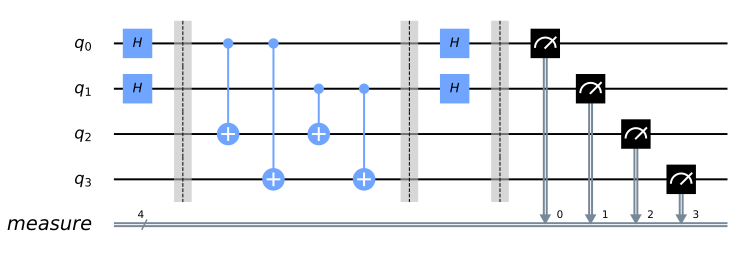

In [4]:
simonCircuit.draw(output='mpl')

{'11': 521, '00': 503}


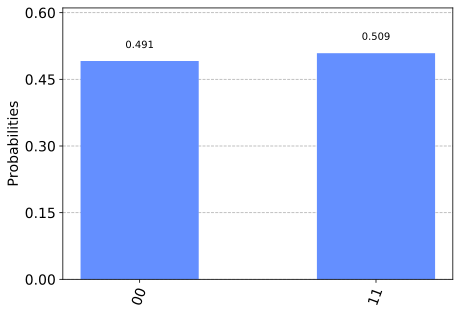

In [5]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simonCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

# Categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# Plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

In [6]:
# Calculate the dot product of the results
def sdotz(a, b):
    accum = 0
    for i in range(len(a)):
        accum += int(a[i]) * int(b[i])
    return (accum % 2)

print('s, z, s.z (mod 2)')
for z_rev in answer_plot:
    z = z_rev[::-1]
    print( '{}, {}, {}.{}={}'.format(s, z, s,z,sdotz(s,z)) )

s, z, s.z (mod 2)
11, 11, 11.11=0
11, 00, 11.00=0


In [7]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmqx2


In [8]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(simonCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


{'11': 521, '00': 503}


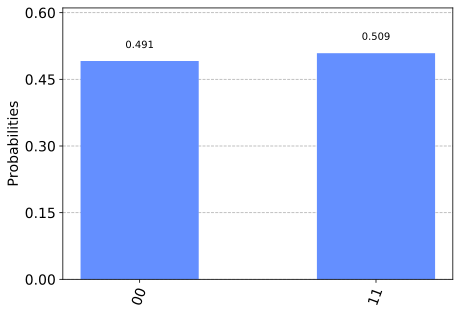

In [9]:
# Categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# Plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

In [10]:
# Calculate the dot product of the most significant results
print('s, z, s.z (mod 2)')
for z_rev in answer_plot:
    if answer_plot[z_rev] >= 0.1*shots:
        z = z_rev[::-1]
        print( '{}, {}, {}.{}={}'.format(s, z, s,z,sdotz(s,z)) )

s, z, s.z (mod 2)
11, 11, 11.11=0
11, 00, 11.00=0
